In [1]:
%pip install traci gym torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import gym
from gym import spaces
import traci
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [3]:
class SumoRampEnv(gym.Env):
    def __init__(self, config_path):
        super(SumoRampEnv, self).__init__()
        
        self.config_path = config_path
        
        self.action_space = spaces.Discrete(4)  
        
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)
        
        self.current_state = None
        self.step_count = 0

    def reset(self):
        """Reset the SUMO simulation."""
        try:
            traci.close()  
        except Exception:
            pass  
        
        traci.start(["sumo", "-c", self.config_path, "--no-warnings"])  
        self.step_count = 0
        
        self.current_state = self.get_state()
        return self.current_state

    def step(self, action):
        """Advance the simulation by one step based on the action taken."""
        if action == 0:
            traci.trafficlight.setPhase("J1", 0)  
            traci.trafficlight.setPhase("J2", 0)  
        elif action == 1:
            traci.trafficlight.setPhase("J1", 1)  
            traci.trafficlight.setPhase("J2", 1)  
        elif action == 2:
            traci.trafficlight.setPhase("J1", 0)  
            traci.trafficlight.setPhase("J2", 1)  
        elif action == 3:
            traci.trafficlight.setPhase("J1", 2)  
            traci.trafficlight.setPhase("J2", 2)

        traci.simulationStep()
        self.step_count += 1
        
        next_state = self.get_state()
        reward = self.calculate_reward(next_state)
        done = self.is_done()
        
        self.current_state = next_state
        return next_state, reward, done, {}

    def get_state(self):
        """Extract state information (e.g., vehicle counts on lanes)."""
        vehicles_on_highway = traci.lane.getLastStepVehicleNumber("E2_0")
        vehicles_on_ramp = traci.lane.getLastStepVehicleNumber("E3_0")
        return np.array([vehicles_on_highway, vehicles_on_ramp], dtype=np.float32)

    def calculate_reward(self, state):
        """Calculate reward based on current state."""
        vehicles_on_highway, vehicles_on_ramp = state
        return -vehicles_on_ramp - vehicles_on_highway  # Example: negative congestion

    def is_done(self):
        """Check if the episode is done."""
        return self.step_count >= 1000

    def close(self):
        """Close SUMO."""
        traci.close()

In [4]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def size(self):
        return len(self.buffer)

In [6]:
env = SumoRampEnv(config_path="try_1.sumocfg")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
dqn_model = DQN(input_dim, output_dim)
optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer()
num_episodes = 500
max_steps_per_episode = 100
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay_duration = num_episodes // 2
rewards_all_episodes = []

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19712\58975970.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states_batch = torch.FloatTensor([exp[0] for exp in experiences])


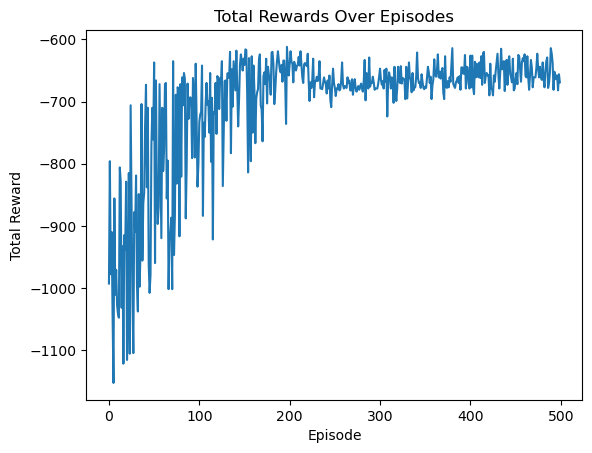

In [7]:
for episode in range(num_episodes):
    state = env.reset()
    total_rewards = 0
    for step in range(max_steps_per_episode):
        epsilon = max(
            epsilon_end,
            epsilon_start - episode / epsilon_decay_duration * (epsilon_start - epsilon_end),
        )
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action_values = dqn_model(torch.FloatTensor(state))
                action = torch.argmax(action_values).item()
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        total_rewards += reward
        if replay_buffer.size() > batch_size:
            experiences = replay_buffer.sample(batch_size)
            states_batch = torch.FloatTensor([exp[0] for exp in experiences])
            actions_batch = torch.LongTensor([exp[1] for exp in experiences]).unsqueeze(1)
            rewards_batch = torch.FloatTensor([exp[2] for exp in experiences])
            next_states_batch = torch.FloatTensor([exp[3] for exp in experiences])
            dones_batch = torch.FloatTensor([exp[4] for exp in experiences])
            with torch.no_grad():
                target_q_values_next = dqn_model(next_states_batch)
                target_q_values_next[dones_batch == 1] = 0.0
            target_q_values_batch = rewards_batch + gamma * target_q_values_next.max(1)[0]
            current_q_values_batch = dqn_model(states_batch).gather(1, actions_batch)
            loss = loss_fn(current_q_values_batch.squeeze(), target_q_values_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        state = next_state
        if done:
            break
    rewards_all_episodes.append(total_rewards)
env.close()
torch.save(dqn_model.state_dict(), "dqn_traffic_light_model_2.pth")
plt.plot(rewards_all_episodes)
plt.title("Total Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [8]:
def load_model(model_path):
    loaded_model = DQN(input_dim, output_dim)
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()  # Set to evaluation mode
    return loaded_model

trained_model = load_model("dqn_traffic_light_model_2.pth")

def run_inference(env, model):
    state = env.reset()
    
    while True:
        with torch.no_grad():
            action_values = model(torch.FloatTensor(state))
            action = torch.argmax(action_values).item()  
        
        next_state, _, done, _ = env.step(action)
        
        if done:
            break
            
env_inference = SumoRampEnv(config_path="try_1.sumocfg")
run_inference(env_inference, trained_model)
env_inference.close()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19712\2428595898.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))
